<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_16_Buckling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 6 buckling loads (lambda = Pcr):
[0.03303427 0.06790045 0.13378717 0.2040656  0.30738654 0.41698325]

Analytical (from MATLAB):
Pc_rSS = 0.008224648693245018
Pc_rCC = 0.032898335083759896


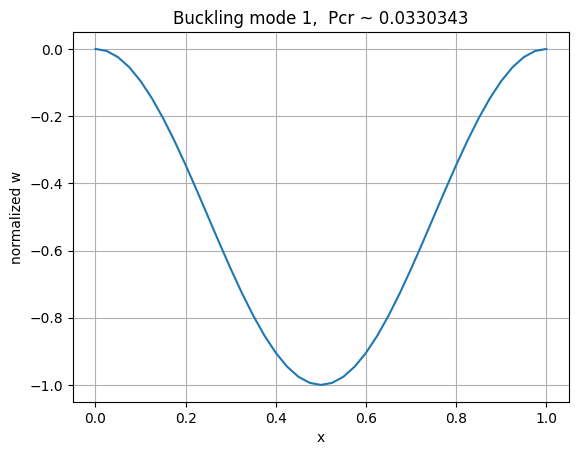

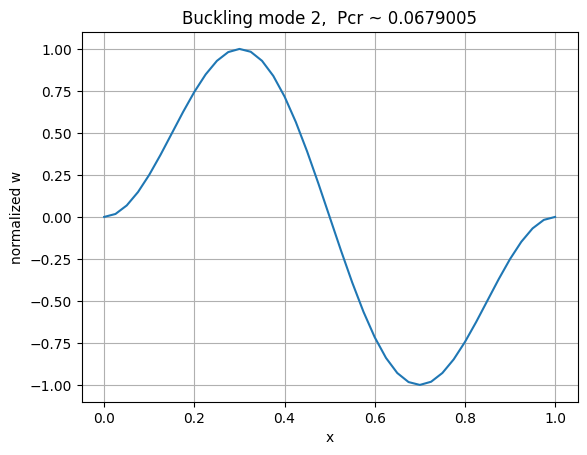

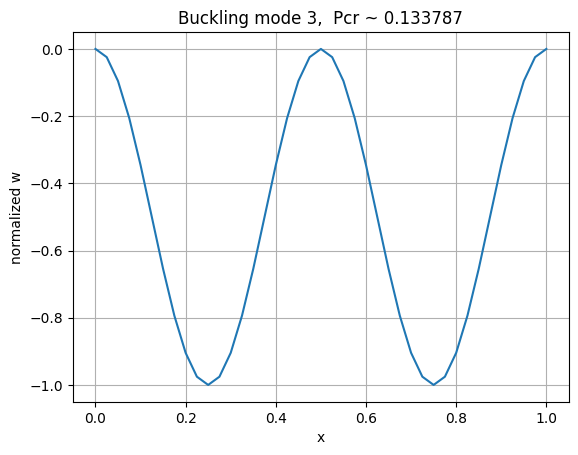

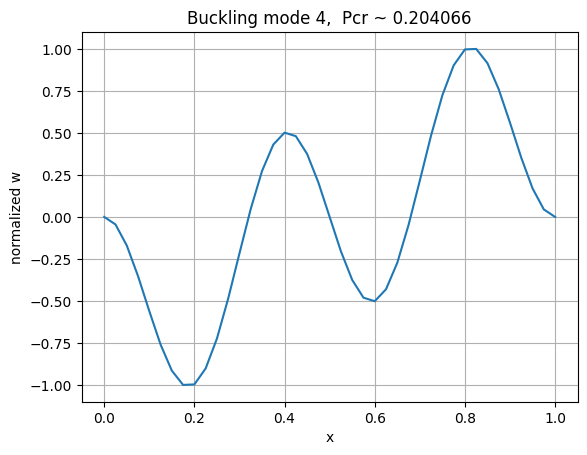

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig

# ============================================================
# shapeFunctionL2
# ============================================================
def shapeFunctionL2(xi):
    N = np.array([0.5*(1-xi), 0.5*(1+xi)], dtype=float)
    dN_dxi = np.array([-0.5, 0.5], dtype=float)
    return N, dN_dxi


# ============================================================
# formStiffnessBucklingTimoshenkoBeam (MATCH screenshots)
# - stiffness K assembled with bending(2-pt) + shear(1-pt)
# - geometric stiffness Kg assembled ONLY on w-DOFs:
#     Kg(indice,indice) += (dN/dx)^T (dN/dx) * w * detJ * P
# - gaussLocations=[0], gaussWeights=[1] for bending part in this buckling file
#   (as shown in the screenshot)
# - shear part uses gaussLocations=[0], gaussWeights=[2]
# ============================================================
def formStiffnessBucklingTimoshenkoBeam(GDoF, numberElements,
                                       elementNodes, numberNodes, xx,
                                       C, P, I, thickness):
    K = np.zeros((GDoF, GDoF), dtype=float)
    Kg = np.zeros((GDoF, GDoF), dtype=float)

    # -------------------------
    # "bending contribution" in this buckling file:
    # gaussLocations=[0.]; gaussWeights=[1.];
    # -------------------------
    gaussLocations = np.array([0.0], dtype=float)
    gaussWeights = np.array([1.0], dtype=float)

    for e in range(numberElements):
        indice = elementNodes[e, :]  # 1-based (2 nodes)
        nodes = indice.astype(int) - 1

        # MATLAB: elementDof = [indice  indice+numberNodes]
        elementDof_1based = np.hstack([indice, indice + numberNodes])
        elementDof = elementDof_1based.astype(int) - 1

        Le = xx[nodes[1]] - xx[nodes[0]]
        detJ = Le / 2.0
        invJ = 1.0 / detJ

        for q in range(len(gaussWeights)):
            xi = gaussLocations[q]
            wq = gaussWeights[q]

            shape, dN_dxi = shapeFunctionL2(xi)
            dN_dx = dN_dxi * invJ

            # B matrix: B(1,ndof+1:2*ndof) = Xderivatives
            # Here ndof=2 => total 4
            B = np.zeros((2, 4), dtype=float)
            B[0, 2:4] = dN_dx

            # K += B'B * wq*detJ*C(1,1)
            K[np.ix_(elementDof, elementDof)] += (B.T @ B) * (wq * detJ * C[0, 0])

            # Kg(indice,indice) += Xderivatives'*Xderivatives*wq*detJ*P
            # (ONLY on w-DOFs)
            Kg[np.ix_(nodes, nodes)] += np.outer(dN_dx, dN_dx) * (wq * detJ * P)

    # -------------------------
    # shear contribution:
    # gaussLocations=[0.]; gaussWeights=[2.];
    # -------------------------
    gaussLocations = np.array([0.0], dtype=float)
    gaussWeights = np.array([2.0], dtype=float)

    for e in range(numberElements):
        indice = elementNodes[e, :]
        nodes = indice.astype(int) - 1
        elementDof_1based = np.hstack([indice, indice + numberNodes])
        elementDof = elementDof_1based.astype(int) - 1

        Le = xx[nodes[1]] - xx[nodes[0]]
        detJ0 = Le / 2.0
        invJ0 = 1.0 / detJ0

        for q in range(len(gaussWeights)):
            xi = gaussLocations[q]
            wq = gaussWeights[q]

            shape, dN_dxi = shapeFunctionL2(xi)
            dN_dx = dN_dxi * invJ0

            # MATLAB:
            # B(2,1:ndof) = Xderivatives
            # B(2,ndof+1:2*ndof) = shape
            B = np.zeros((2, 4), dtype=float)
            B[1, 0:2] = dN_dx
            B[1, 2:4] = shape

            K[np.ix_(elementDof, elementDof)] += (B.T @ B) * (wq * detJ0 * C[1, 1])

    return K, Kg


# ============================================================
# MAIN: problem16Buckling.m
# ============================================================
E = 10e6
poisson = 0.333
L = 1.0
thickness = 0.001

I = thickness**3 / 12.0
EI = E * I
kapa = 5/6
A = 1 * thickness

P = 1.0  # uniform pressure (used to build Kg)

G = E / (2.0 * (1.0 + poisson))
C = np.array([[EI, 0.0],
              [0.0, kapa * thickness * G]], dtype=float)

# mesh
numberElements = 40
xx = np.linspace(0.0, L, numberElements + 1)
numberNodes = len(xx)
GDoF = 2 * numberNodes

elementNodes = np.zeros((numberElements, 2), dtype=int)
for i in range(numberElements):
    elementNodes[i, 0] = i + 1
    elementNodes[i, 1] = i + 2

# assemble
K, Kg = formStiffnessBucklingTimoshenkoBeam(
    GDoF, numberElements, elementNodes, numberNodes, xx, C, P, I, thickness
)

# ------------------------------------------------------------
# Boundary conditions
# CC (clamped-clamped) like the screenshot's active block:
# fixedNodeW = [first node, last node]
# fixedNodeTX = fixedNodeW
# ------------------------------------------------------------
fixedNodeW = np.array([1, numberNodes], dtype=int)
fixedNodeTX = fixedNodeW.copy()

prescribedDof = np.hstack([fixedNodeW, fixedNodeTX + numberNodes]).astype(int) - 1
activeDof = np.setdiff1d(np.arange(GDoF), prescribedDof)

# ------------------------------------------------------------
# Buckling eigenproblem: K * v = lambda * Kg * v
# MATLAB: [V,D]=eig(K(active), Kg(active)); D=diag(D); sort
# ------------------------------------------------------------
eigvals, eigvecs = eig(K[np.ix_(activeDof, activeDof)], Kg[np.ix_(activeDof, activeDof)])
eigvals = np.real(eigvals)

# keep positive finite eigenvalues
mask = np.isfinite(eigvals) & (eigvals > 0)
eigvals = eigvals[mask]
eigvecs = eigvecs[:, mask]

idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("First 6 buckling loads (lambda = Pcr):")
print(eigvals[:6])

# ------------------------------------------------------------
# Analytical Pcr formulas in MATLAB snippet (as printed there)
# ------------------------------------------------------------
Pc_rSS = (np.pi**2)*E*I/(L**2) * (1.0/(1.0 + (np.pi**2)*E*I/(L**2 * kapa * G * A)))
Pc_rCC = (np.pi**2)*E*I/((L/2.0)**2) * (1.0/(1.0 + (np.pi**2)*E*I/( (L**2/4.0) * kapa * G * A)))

print("\nAnalytical (from MATLAB):")
print("Pc_rSS =", Pc_rSS)
print("Pc_rCC =", Pc_rCC)

# ------------------------------------------------------------
# Plot first few buckling modes (w only)
# ------------------------------------------------------------
modeNumber = 4
modes_to_plot = min(modeNumber, eigvecs.shape[1])

for m in range(modes_to_plot):
    Vfull = np.zeros(GDoF, dtype=float)
    Vfull[activeDof] = np.real(eigvecs[:, m])
    w_mode = Vfull[:numberNodes]
    w_mode = w_mode / (np.max(np.abs(w_mode)) + 1e-12)

    plt.figure()
    plt.plot(xx, w_mode)
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("normalized w")
    plt.title(f"Buckling mode {m+1},  Pcr ~ {eigvals[m]:.6g}")
    plt.show()
